In [1]:
import numpy as np

from scipy.integrate import solve_ivp

import torch
from sbi import utils as sbi_utils
from sbi.inference import NPE, simulate_for_sbi
from sbi import analysis

from sbi.utils.user_input_checks import (
    check_sbi_inputs,
    process_prior,
    process_simulator,
)


from sbi.neural_nets.embedding_nets import FCEmbedding
from sbi.neural_nets import posterior_nn


2025-04-23 13:48:07.970304: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745408887.984482   20193 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745408887.988626   20193 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745408887.999525   20193 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745408887.999548   20193 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745408887.999549   20193 computation_placer.cc:177] computation placer alr

In [2]:
def multiphase_simulator(theta):
    """
    Simple 1D transient multiphase simulator for gas-liquid flow.
    Args:
        theta (array-like): [L, D, P0, alpha0, G, LFR]
            L: pipe length (m)
            D: pipe diameter (m)
            P0: initial pressure (Pa)
            alpha0: initial gas volume fraction (0-1)
            G: gas superficial velocity (m/s)
            LFR: liquid flow rate (m^3/s)
    Returns:
        np.ndarray: time series of pressure and gas fraction
    """
    # Unpack parameters
    L, D, P0, alpha0, G, LFR = theta
    A = np.pi * (D / 2)**2

    # Constants
    rho_g = 1.2     # kg/m^3
    rho_l = 1000.0  # kg/m^3
    k_p = 0.005 * (1 / D)**0.2      # pressure loss factor (empirical)
    k_a = 0.01      # gas entrainment rate

    # Initial values
    y0 = [P0, alpha0]  # [pressure, gas volume fraction]

    def rhs(t, y):
        P, alpha = y
        A = np.pi * (D / 2)**2
        U_l = LFR / A
        dP_dt = -k_p * alpha * G / (rho_g * A) * (L / 1000)
        dalpha_dt = k_a * (1 - alpha) * G - 0.001 * alpha * (1 + U_l / G) # net gas inflow - escape
        return [dP_dt, dalpha_dt]

    # Simulate over 100 seconds
    t_span = (0, 100)
    t_eval = np.linspace(*t_span, 200)
    sol = solve_ivp(rhs, t_span, y0, t_eval=t_eval, method='RK45')

    if not sol.success:
        raise RuntimeError("Simulation failed")

    # Return only the key observable parts
    pressure = sol.y[0]
    alpha_g = sol.y[1]
    
    # Optionally: summarize outputs for sbi
    # For now: return raw samples
    return np.stack([pressure, alpha_g], axis=0)

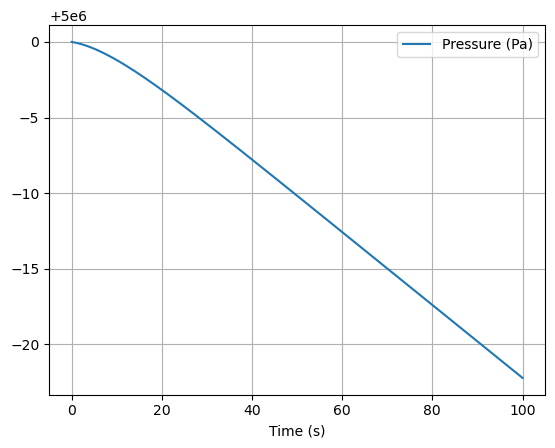

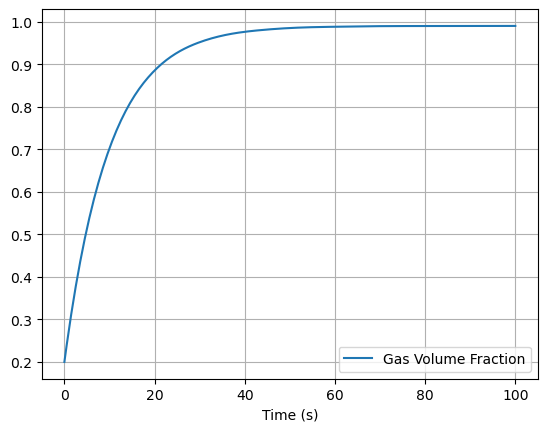

In [3]:
theta_example = [1000, 0.5, 5e6, 0.2, 10.0, 0.01]
output = multiphase_simulator(theta_example)

import matplotlib.pyplot as plt
t = np.linspace(0, 100, 200)
plt.plot(t, output[0], label="Pressure (Pa)")
plt.xlabel("Time (s)")
plt.legend()
plt.grid(True)
plt.show()

plt.plot(t, output[1], label="Gas Volume Fraction")
plt.xlabel("Time (s)")
plt.legend()
plt.grid(True)
plt.show()

In [4]:
def simulator(theta_tensor):
    theta_np = theta_tensor.numpy()
    output = multiphase_simulator(theta_np)
    summary = output[:, ::20].flatten()  # Subsample and flatten
    return torch.tensor(summary, dtype=torch.float32)

In [5]:
# Parameters: [L, D, P0, alpha0, G, LFR]
prior = sbi_utils.BoxUniform(
    low=torch.tensor([500.0, 0.1, 3e6, 0.1, 1.0, 0.005]),   # realistic lower bounds
    high=torch.tensor([2000.0, 0.6, 10e6, 0.9, 20.0, 0.05])  # realistic upper bounds
)

In [6]:
def simulator_wrapper(theta):
    outputs = []
    theta_np = theta.numpy()
    if theta_np.ndim == 2:
        theta_np = theta_np[0]  # Extract the single sample from the batch
    try:
        output = multiphase_simulator(theta_np)
        summary = output[:, ::100].flatten()  # Subsample the time series
    except Exception:
        summary = np.full((2 * 10,), np.nan)  # Match output shape
    outputs.append(torch.tensor(summary, dtype=torch.float32))
    return torch.stack(outputs)

In [7]:
inference = NPE(prior=prior)

In [8]:
num_simulations = 1000

theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=num_simulations)
density_estimator = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior(density_estimator)

  0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 452 epochs.

In [9]:
low = prior.base_dist.low.numpy()
high = prior.base_dist.high.numpy()
limits = [[l, h] for l, h in zip(low, high)]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

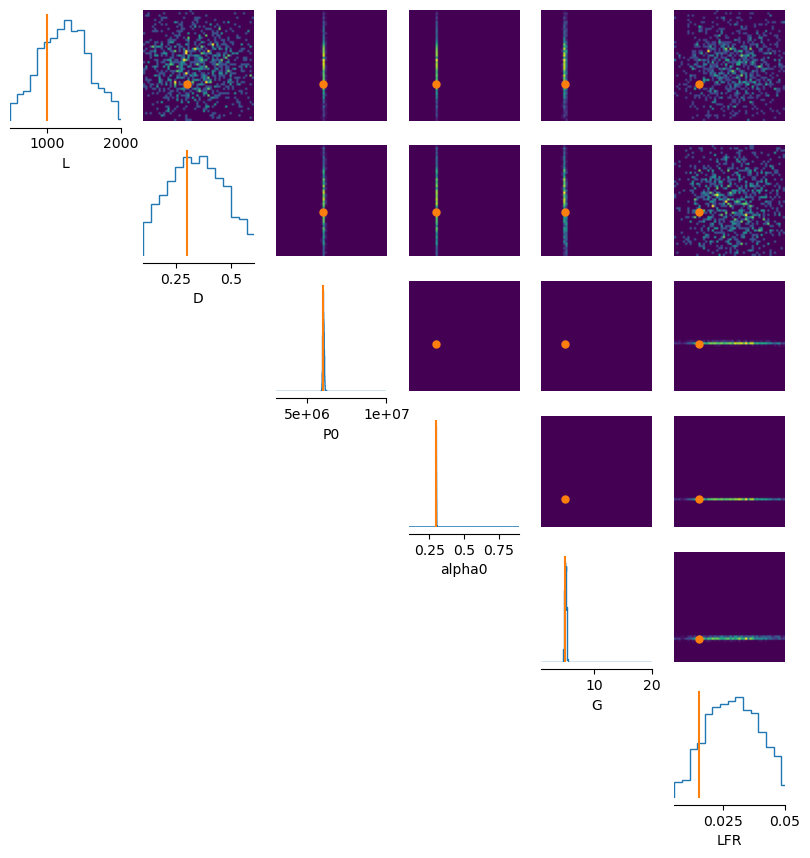

In [10]:
# Assume we simulate a ground-truth observation
true_theta = torch.tensor([1000.0, 0.3, 6e6, 0.3, 5.0, 0.015])
x_o = simulator_wrapper(true_theta)

# Condition the posterior on the observed data
posterior_samples = posterior.sample((1000,), x=x_o)

fig, ax = analysis.pairplot(
    posterior_samples,
    points=true_theta.unsqueeze(0),
    labels=['L', 'D', 'P0', 'alpha0', 'G', 'LFR'],
    limits=limits
)

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

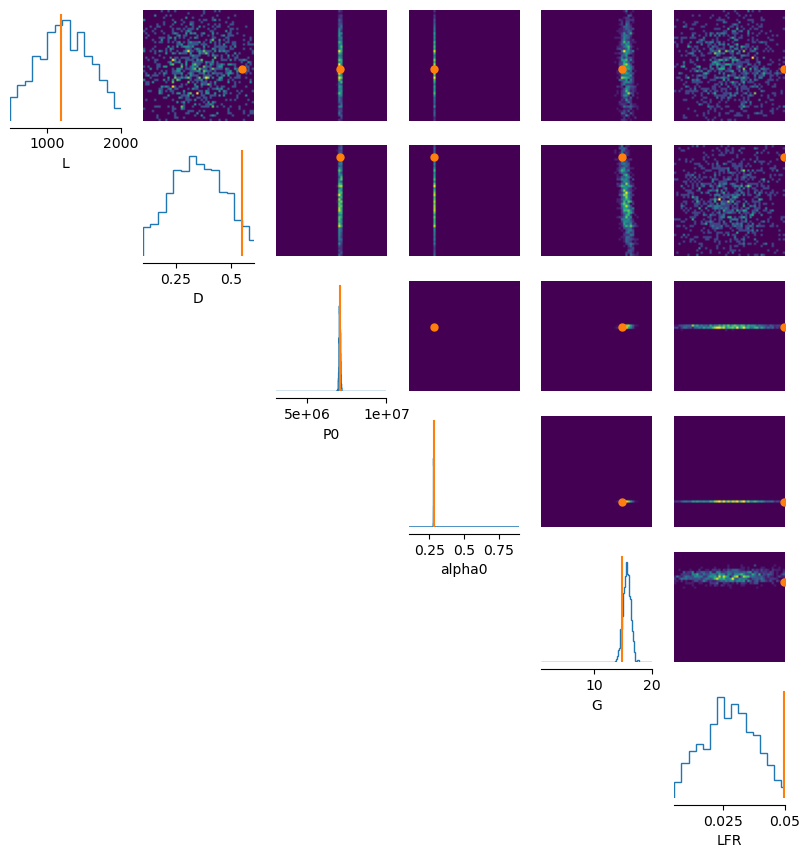

In [11]:
# Assume we simulate a ground-truth observation
sample_theta = prior.sample()
sample_x_o = simulator_wrapper(sample_theta)

# Condition the posterior on the observed data
sample_posterior_samples = posterior.sample((1000,), x=sample_x_o)

fig, ax = analysis.pairplot(
    sample_posterior_samples,
    points=sample_theta.unsqueeze(0),
    labels=['L', 'D', 'P0', 'alpha0', 'G', 'LFR'],
    limits=limits
)

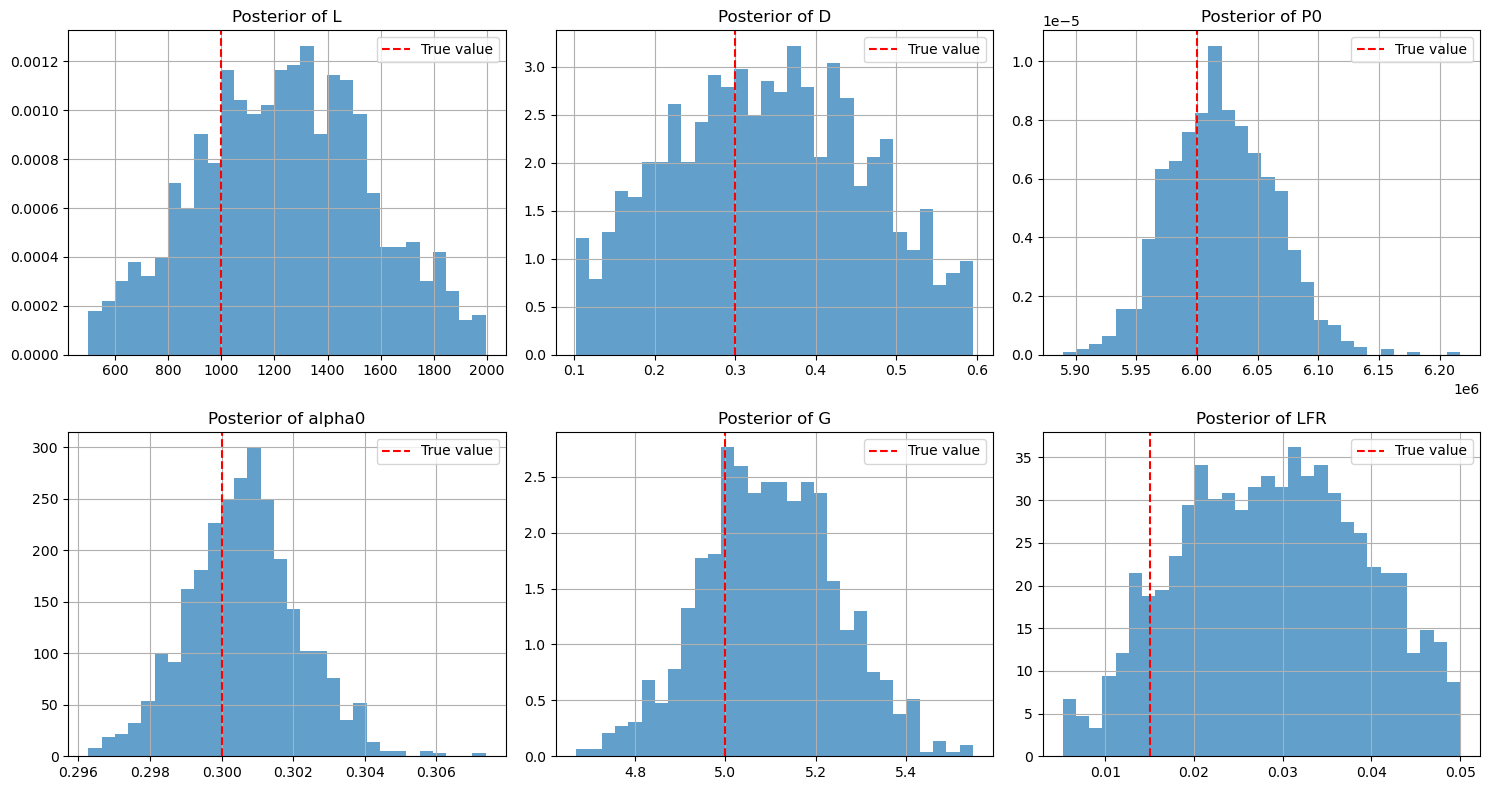

In [12]:
param_names = ['L', 'D', 'P0', 'alpha0', 'G', 'LFR']
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
axs = axs.flatten()

for i in range(6):
    axs[i].hist(posterior_samples[:, i].numpy(), bins=30, density=True, alpha=0.7)
    axs[i].axvline(true_theta[i].item(), color='r', linestyle='--', label='True value')
    axs[i].set_title(f"Posterior of {param_names[i]}")
    axs[i].legend()
    axs[i].grid(True)

plt.tight_layout()
plt.show()

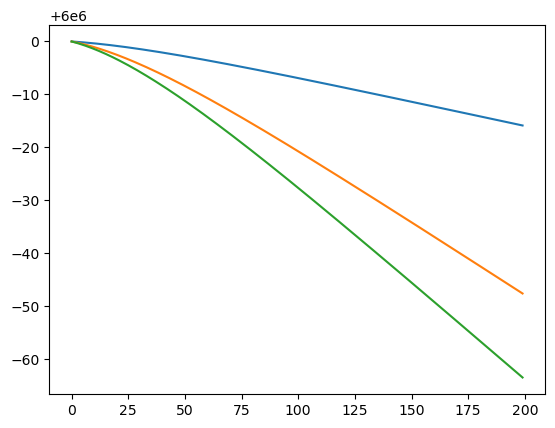

In [13]:
for val in [500, 1500, 2000]:
    theta_test = [val, 0.3, 6e6, 0.3, 5.0, 0.015]
    output = multiphase_simulator(theta_test)
    plt.plot(output[0], label=f"L={val}")

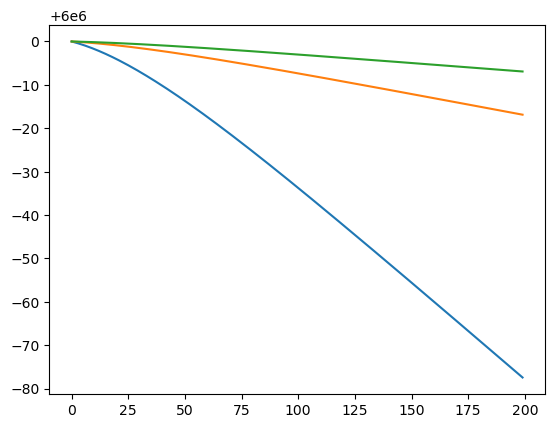

In [14]:
for val in [0.2, 0.4, 0.6]:
    theta_test = [1000, val, 6e6, 0.3, 5.0, 0.015]
    output = multiphase_simulator(theta_test)
    plt.plot(output[0], label=f"L={val}")

In [15]:
embedding_net = torch.nn.Sequential(
    torch.nn.Linear(400, 100),  # e.g., if you keep 200 timesteps x 2 features
    torch.nn.ReLU(),
    torch.nn.Linear(100, 30),
    torch.nn.ReLU(),
    torch.nn.Linear(30, 10)
)

def simulator_wrapper(theta):
    outputs = []
    theta_np = theta.numpy()
    if theta_np.ndim == 2:
        theta_np = theta_np[0]
    output = multiphase_simulator(theta_np)  # shape: (2, 200)
    summary = output.reshape(-1)             # flatten to (400,)
    outputs.append(torch.tensor(summary, dtype=torch.float32))
    return torch.stack(outputs)

density_estimator = posterior_nn(model='maf', embedding_net=embedding_net)
inference = NPE(prior=prior, density_estimator=density_estimator)

In [16]:
num_simulations = 1000

theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=num_simulations)
density_estimator = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior(density_estimator)

  0%|          | 0/1000 [00:00<?, ?it/s]

 Neural network successfully converged after 661 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

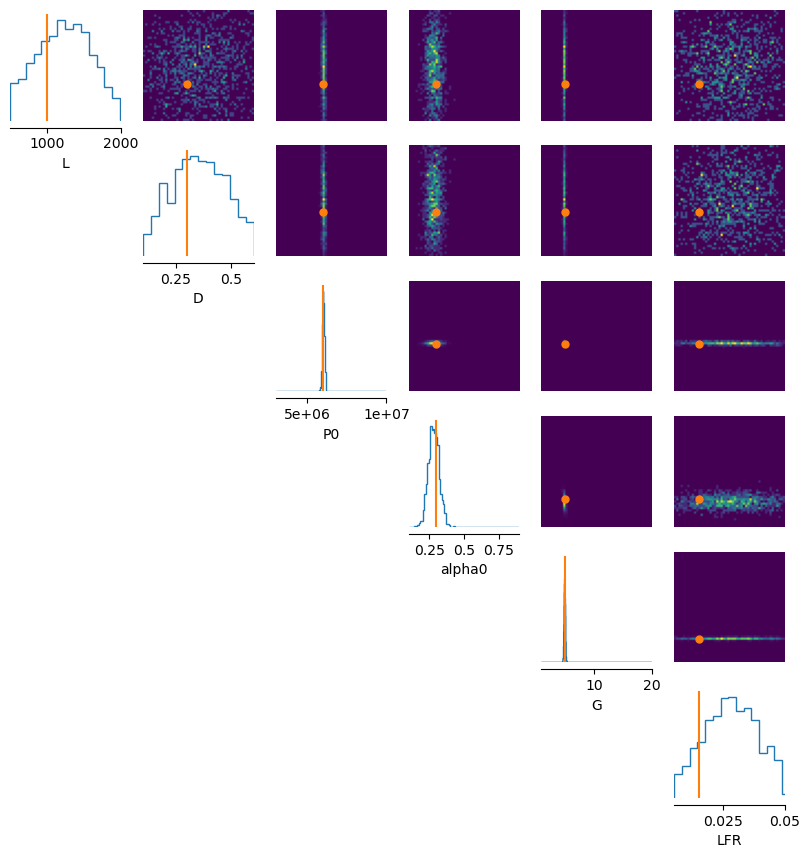

In [17]:
# Assume we simulate a ground-truth observation
true_theta = torch.tensor([1000.0, 0.3, 6e6, 0.3, 5.0, 0.015])
x_o = simulator_wrapper(true_theta)

# Condition the posterior on the observed data
posterior_samples = posterior.sample((1000,), x=x_o)

fig, ax = analysis.pairplot(
    posterior_samples,
    points=true_theta.unsqueeze(0),
    labels=['L', 'D', 'P0', 'alpha0', 'G', 'LFR'],
    limits=limits
)